In [22]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [28]:

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 123
learning_rate = 0.1
num_epochs = 100
batch_size = 256

num_features = 784
num_classes = 10

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape) 
    print('Image label dimensions:', labels.shape)
    break



Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [29]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    y_cpu = y.to(torch.device('cpu'))
    y_onehot.scatter_(1, y_cpu.view(-1, 1).long(), 1).float()
    return y_onehot.to(DEVICE)

def softmax(z):
    return (torch.exp(z.t()) / torch.sum(torch.exp(z), dim=1)).t()
                    
def cross_entropy(softmax, y_target):
    return -torch.sum(torch.log(softmax) * (y_target), dim=1)

class SoftmaxRegression1():
    def __init__(self, num_features, num_classes):
        self.num_features = num_features
        self.num_classes = num_classes
        self.weights = torch.zeros(num_classes, num_features, # h x m
                                   dtype=torch.float32, device=DEVICE)
        self.bias = torch.zeros(num_classes, dtype=torch.float32, device=DEVICE) # h

    def forward(self, x):
        logits = torch.mm(x, self.weights.t()) + self.bias # net inputs
        probas = softmax(logits) # activations
        return logits, probas
        
    def backward(self, x, y, probas):  
        grad_loss_wrt_w = -torch.mm(x.t(), y - probas).t()
        grad_loss_wrt_b = -torch.sum(y - probas)
        return grad_loss_wrt_w, grad_loss_wrt_b
            
    def predict_labels(self, x):
        logits, probas = self.forward(x)
        labels = torch.argmax(probas, dim=1)
        return labels    
            
    def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
        return accuracy
    
    def train(self, x, y, num_epochs, learning_rate=0.01):
        epoch_cost = []
        for e in range(num_epochs):
            
            y_onehot = to_onehot(y, num_classes=self.num_classes)
            
            logits, probas = self.backward(x)
            
            grad_w, grad_b = self.backward(x, y_onehot, probas)

            self.weights -= learning_rate * grad_w / y.size(0)
            self.bias -= learning_rate * grad_b / y.size(0)
            
            logits, probas = self.forward(x)
            cost = torch.mean(cross_entropy(probas, y_onehot))
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % cost)
            epoch_cost.append(cost)
        return epoch_cost

In [30]:

model1 = SoftmaxRegression1(num_features=num_features, num_classes=num_classes)
for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
        # Plotting the images and their labels
        # fig, ax = plt.subplots(1, 4, figsize=(15, 4))
        # for i in range(4):
        #     ax[i].imshow(features[i].view(28, 28).cpu(), cmap='gray')
        #     ax[i].set_title(f'Label: {targets[i].item()}')
        #     ax[i].axis('off')
        # plt.show()
        # Train on the current batch
        model1.train(features, targets, num_epochs=1, learning_rate=learning_rate)

print('\nModel parameters:')
print('  Weights: %s' % model1.weights)
print('  Bias: %s' % model1.bias)

Epoch: 001 | Train ACC: 0.578 | Cost: 2.179
Epoch: 001 | Train ACC: 0.602 | Cost: 2.077
Epoch: 001 | Train ACC: 0.633 | Cost: 1.998
Epoch: 001 | Train ACC: 0.746 | Cost: 1.915
Epoch: 001 | Train ACC: 0.684 | Cost: 1.843
Epoch: 001 | Train ACC: 0.719 | Cost: 1.779
Epoch: 001 | Train ACC: 0.754 | Cost: 1.732
Epoch: 001 | Train ACC: 0.730 | Cost: 1.658
Epoch: 001 | Train ACC: 0.777 | Cost: 1.598
Epoch: 001 | Train ACC: 0.785 | Cost: 1.522
Epoch: 001 | Train ACC: 0.816 | Cost: 1.496
Epoch: 001 | Train ACC: 0.797 | Cost: 1.461
Epoch: 001 | Train ACC: 0.809 | Cost: 1.418
Epoch: 001 | Train ACC: 0.828 | Cost: 1.335
Epoch: 001 | Train ACC: 0.820 | Cost: 1.335
Epoch: 001 | Train ACC: 0.828 | Cost: 1.267
Epoch: 001 | Train ACC: 0.797 | Cost: 1.234
Epoch: 001 | Train ACC: 0.797 | Cost: 1.233
Epoch: 001 | Train ACC: 0.809 | Cost: 1.196
Epoch: 001 | Train ACC: 0.824 | Cost: 1.113
Epoch: 001 | Train ACC: 0.809 | Cost: 1.209
Epoch: 001 | Train ACC: 0.812 | Cost: 1.131
Epoch: 001 | Train ACC: 0.805 | 

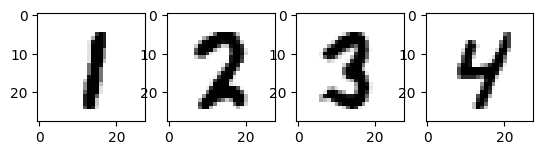

In [39]:
import matplotlib.pyplot as plt
batch_num =50
for i, (features, targets) in enumerate(test_loader):
    if i == batch_num:
        break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)


plt.show()

In [40]:
_, predictions = model1.forward(features[:4].view(-1, 28*28).to(DEVICE))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([1, 7, 8, 4])
